# ***4. Estimating Proportions***

> ## **4.1 The Euro Problem and Binomial Distribution**
***

The probability that we get a total of $k$ heads in $n$ tosses is given by the binomial distribution:

$$\binom{n}{k} p^k (1-p)^{n-k}$$

We can use the SciPy function `binom.pmf` to evaluate a certain result. For example, if we flip a coin `n=2` times and the probability of heads is `p=0.5`, here's the probability of getting `k=1` heads:

In [6]:
from scipy.stats import binom
import numpy as np
from empiricaldist import Pmf

n = 2
p = 0.5
k = 1

# Single value for k
print("Probability of getting 1 head in 2 tosses: ", binom.pmf(k, n, p))
# Array of values for k
k_array = np.arange(n+1) # Takes three positions (0,1,2)
p_array = binom.pmf(k_array, n, p)
print("Probability of getting 0, 1 and 2 heads in 2 tosses: ", ps)

# Probabilities put into a PMF
pmf_k = Pmf(p_array, k_array)
pmf_k


Probability of getting 1 head in 2 tosses:  0.5000000000000002
Probability of getting 0, 1 and 2 heads in 2 tosses:  [0.25 0.5  0.25]


,probs
0,0.25
1,0.50
2,0.25


The following function computes the binomial distribution for given values of `n` and `p` and returns a `Pmf` that represents the result.

In [8]:
def make_binomial(n, p):
    """Make a binomial Pmf."""
    ks = np.arange(n+1)
    ps = binom.pmf(ks, n, p)
    return Pmf(ps, ks)

Most likely quantity:  125
Probability of getting 125 heads in 250 tosses:  0.050412213147309655


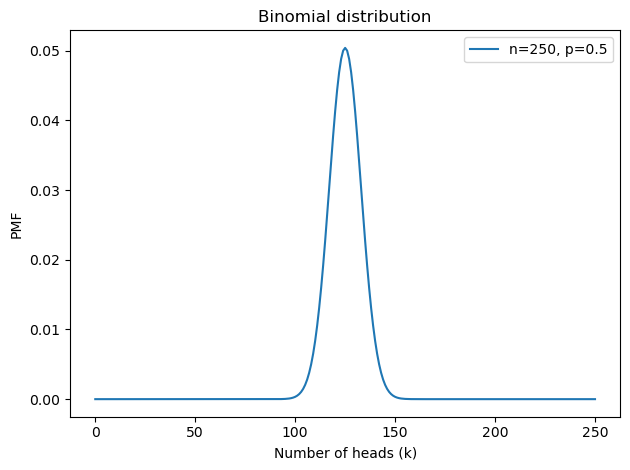

In [17]:
pmf_k = make_binomial(n=250, p=0.5)

from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkBayes2/raw/master/soln/utils.py')

from utils import decorate

pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

# Most likely quantity in this distribution
print("Most likely quantity: ", pmf_k.max_prob())
print("Probability of getting 125 heads in 250 tosses: ", pmf_k[125])

But even though it is the most likely quantity, the probability that we get exactly 125 heads is only about 5%. If we wanted to see compute the total probability of a quantity (such as 140 heads, for example) greater or equal to a fixed threshold, we can define the next function:

In [20]:
def prob_ge(pmf, threshold):
    """Probability of quantities greater than threshold."""
    ge = (pmf.qs >= threshold)
    total = pmf[ge].sum()
    return total

print("Probability of getting 140 heads in 250 tosses: ", pmf_k[140])
print("Probability of getting 140 heads or more in 250 tosses: ", prob_ge(pmf_k, 140))

Probability of getting 140 heads in 250 tosses:  0.008357181724918188
Probability of getting 140 heads or more in 250 tosses:  0.03321057562002166


A statistical statement appeared in The Guardian on Friday January 4, 2002:

> _When spun on edge 250 times, a Belgian one-euro coin came up heads 140 times and tails 110.  \`It looks very suspicious to me,' said Barry Blight, a statistics lecturer at the London School of Economics.  \`If the coin were unbiased, the chance of getting a result as extreme as that would be less than 7%.'_

The result, as we saw, is about 3.3%, which is less than the quoted 7%. The reason for the difference is that the statistician includes all outcomes “as extreme as” 140, which includes outcomes less than or equal to 110.

To see where that comes from, recall that the expected number of heads is 125. If we get 140, we’ve exceeded that expectation by 15. And if we get 110, we have come up short by 15. 7% is the sum of both of these “tails”, as shown in the following figure.

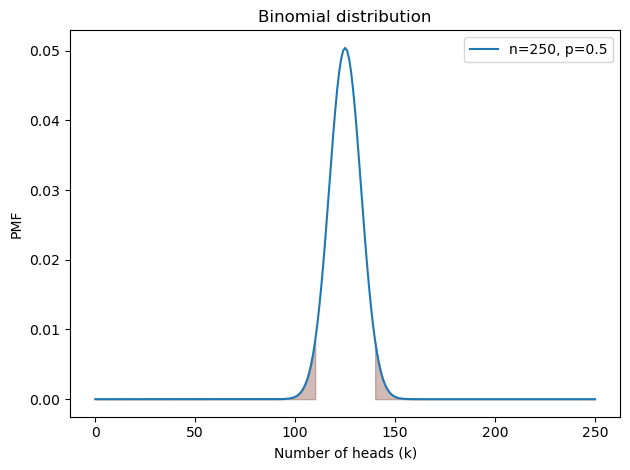

In [21]:
import matplotlib.pyplot as plt

def fill_below(pmf):
    qs = pmf.index
    ps = pmf.values
    plt.fill_between(qs, ps, 0, color='C5', alpha=0.4)

qs = pmf_k.index
fill_below(pmf_k[qs>=140])
fill_below(pmf_k[qs<=110])
pmf_k.plot(label='n=250, p=0.5')

decorate(xlabel='Number of heads (k)',
         ylabel='PMF',
         title='Binomial distribution')

Here's how we compute the probability of both tails:

In [35]:
left = pmf_k.prob_le(110)
right = pmf_k.prob_ge(140)
total = left + right
print("Total Probability of an extreme outcome: ", total)

Total Probability of an extreme outcome:  0.06642115124004333


> ## **4.2 Bayesian Estimation**
***

Any given coin has some probability of landing heads up when spun on edge; I'll call this probability `x`. We can use Bayes's theorem and the observed data to estimate `x`. For simplicity, I'll start with a uniform prior, which assumes that all values of `x` are equally likely.
That might not be a reasonable assumption, so we'll come back and consider other priors later. We can make a uniform prior like this:

Most likely value for the probability of landing heads:  0.56


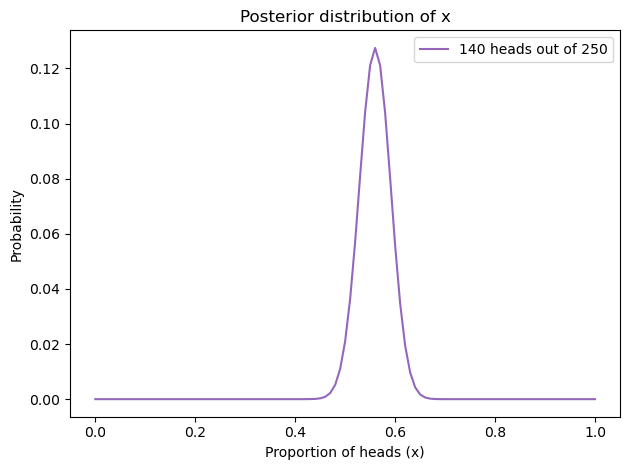

In [ ]:
# Creates an array of 101 values evenly spaced between 0 and 1 
hypos = np.linspace(0, 1, 101)
# Pmf object with a prior probability of 1 uniformly
prior = Pmf(1, hypos)

# Define the likelihoods
likelihood_heads = hypos  # [0.00, 0.01, 0.02, ..., 0.99, 1.00] - P(H|θ) = θ
likelihood_tails = 1 - hypos # [1.00, 0.99, 0.98, ..., 0.01, 0.00] - P(T|θ) = 1 - θ

# Put the likelihoods for heads and tails in a dictionary to make the updates easier
likelihood = {
    'H': likelihood_heads,
    'T': likelihood_tails
}

# To represent the data, I'll construct a string with `H` repeated 140 times and `T` repeated 110 times.
dataset = 'H' * 140 + 'T' * 110

# The pmf argument represents the prior and dataset is just a sequence of characters
def update(pmf, dataset):
    """Update pmf with a given sequence of H and T."""
    for data in dataset:
        pmf *= likelihood[data]
    pmf.normalize()
    
posterior = prior.copy()
update(posterior, dataset)

# Plot
def decorate_euro(title):
    decorate(xlabel='Proportion of heads (x)',
             ylabel='Probability',
             title=title)

posterior.plot(label='140 heads out of 250', color='C4')
decorate_euro(title='Posterior distribution of x')

print("Most likely value for the probability of landing heads: ", posterior.max_prob())

The posterior distribution represents our beliefs about `x` after seeing the data. It indicates that values less than 0.4 and greater than 0.7 are unlikely; values between 0.5 and 0.6 are the most likely. In fact, the most likely value for `x` is 0.56 which is the proportion of heads in the dataset, `140/250`.

As I said earlier, a uniform distribution might not be the best fit, since we know not all probabilities are equally likely. It might be more reasonable to choose a prior that gives higher probability to values of x near 0.5 and lower probability to extreme values, like a triangle-shaped prior.

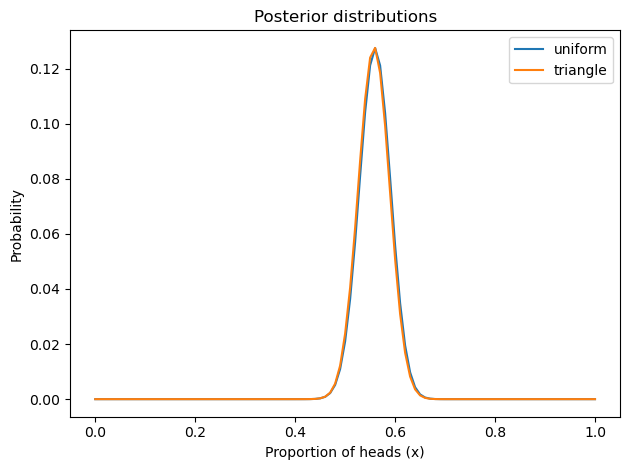

In [ ]:
# Uniform prior
uniform = Pmf(1, hypos, name='uniform')
uniform.normalize()

# Triangle prior
ramp_up = np.arange(50)
ramp_down = np.arange(50, -1, -1)
a = np.append(ramp_up, ramp_down)
triangle = Pmf(a, hypos, name='triangle')
triangle.normalize()

# Updates
update(uniform, dataset)
update(triangle, dataset)

# Plot
uniform.plot()
triangle.plot()
decorate_euro(title='Posterior distributions')

The differences between the posterior distributions are barely visible, and so small they would hardly matter in practice. 

- This is an example of swamping the priors: with enough data, people who start with different priors will tend to converge on the same posterior distribution.

> ## **4.3 The Binomial Likelihood Function**
***

A more efficient alternative is to compute the likelihood of the entire dataset at once.For each hypothetical value of `x`, we have to compute the probability of getting 140 heads out of 250 spins. We can use SciPy to compute it. The following function takes a `Pmf` that represents a prior distribution and a tuple of integers that represent the data

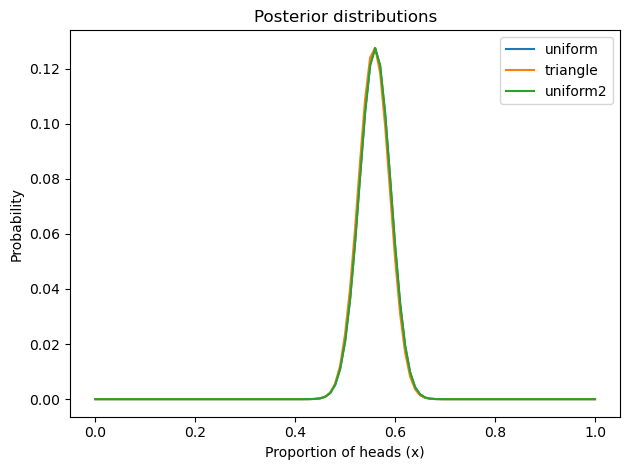

In [ ]:
from scipy.stats import binom

def update_binomial(pmf, data):
    """Update pmf using the binomial distribution."""
    k, n = data
    xs = pmf.qs
    likelihood = binom.pmf(k, n, xs)
    pmf *= likelihood
    pmf.normalize()
    
# Define a uniform prior, the data all at once and do the update
uniform2 = Pmf(1, hypos, name='uniform2')
data = 140, 250
update_binomial(uniform2, data)

# Plot
uniform.plot()
triangle.plot()
uniform2.plot()
decorate_euro(title='Posterior distributions')


It's practically the same.

> **Exercise:** _In Major League Baseball, most players have a batting average between .200 and .330, which means that their probability of getting a hit is between 0.2 and 0.33. Suppose a player appearing in their first game gets 3 hits out of 3 attempts. What is the posterior distribution for their probability of getting a hit?_

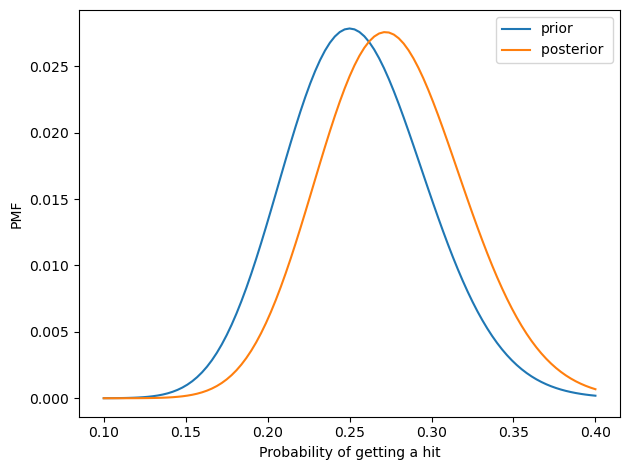

In [65]:
# Define the prior
hypos = np.linspace(0.1, 0.4, 101)
prior = Pmf(1, hypos)

# Define likelihoods
likelihood = {
    'Y': hypos,
    'N': 1 - hypos
}
#              %25        %75
dataset = 'Y' * 25 + 'N' * 75
# Do the update for the prior
update(prior, dataset)

# Do the update for the posterior
dataset = 'Y' * 3
posterior = prior.copy()
update(posterior, dataset)

# Plot
prior.plot(label='prior')
posterior.plot(label='posterior ')
decorate(xlabel='Probability of getting a hit',
         ylabel='PMF')

> **Exercise:** _Whenever you survey people about sensitive issues, you have to deal with social desirability bias, which is the tendency of people to adjust their answers to show themselves in the most positive light. One way to improve the accuracy of the results is randomized response.As an example, suppose you want to know how many people cheat on their taxes. If you ask them directly, it is likely that some of the cheaters will lie. You can get a more accurate estimate if you ask them indirectly, like this: Ask each person to flip a coin and, without revealing the outcome,_
>
> * _If they get heads, they report YES._
>
> * _If they get tails, they honestly answer the question "Do you cheat on your taxes?"_
>
> _If someone says YES, we don't know whether they actually cheat on their taxes; they might have flipped heads.
> Knowing this, people might be more willing to answer honestly._
>
> _Suppose you survey 100 people this way and get 80 YES and 20 NO.  Based on this data, what is the posterior distribution for the fraction of people who cheat on their taxes?  What is the most likely quantity in the posterior distribution?_

0.6

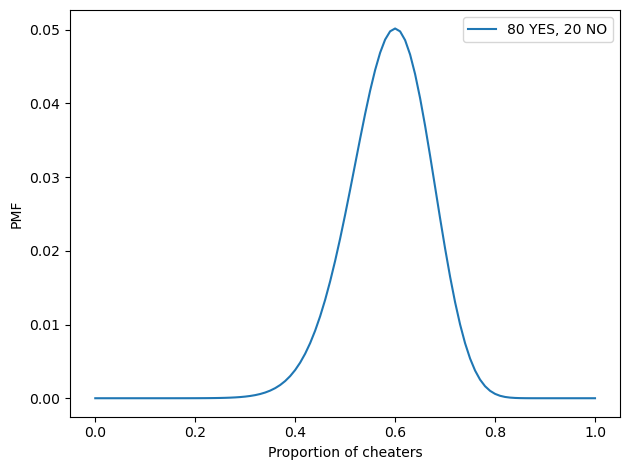

In [ ]:
hypos = np.linspace(0, 1, 101)
prior = Pmf(1, hypos)

# A person will say YES if either:
# They flipped heads (happens 50% of the time).
# They flipped tails (happens 50% of the time) and they actually cheat (which happens with probability x represented by hypos)
# Dividing by 2 scales down the probabilities to account for the fact that only half of the survey responses are truthful.

likelihood = {
    'Y': 0.5 + hypos/2,
    'N': (1-hypos)/2
}

# Update 
dataset = 'Y' * 80 + 'N' * 20
posterior = prior.copy()
update(posterior, dataset)

# Plot 
posterior.plot(label='80 YES, 20 NO')
decorate(xlabel='Proportion of cheaters',
         ylabel='PMF')

posterior.max_prob()